In [1]:
import numpy as np
import os,sys,re,random
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
%matplotlib inline

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
def RunSysCmd(cmd):
    import subprocess
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
    (output, err) = p.communicate()
    p_status = p.wait()
    print(output.decode('utf-8'))
def show(d, f, n=None):
    CIFAR10_LABELS_LIST = [ "airplane", "automobile", "bird", "cat", "deer",
                           "dog", "frog", "horse", "ship", "truck" ]
    if(n==None):
        R = 1
    else:
        R = n
    for i in range(R):
        if(i%4==0):
            N = R-i
            if(N > 4): N = 4
            fig, axs = plt.subplots(1, N) 
        I = i + f
        im = d[b'data'][I].reshape(3,32,32)
        # convert from CHW to HWC
        im = np.transpose(im, (1,2,0))
        try:
            ax = axs[i%N]
        except:
            ax = axs
        ax.imshow(im)
        #name=' '.join(d[b'filenames'][i].decode('utf-8').split('_')[:2]+[str(d[b'labels'][i])])
        label =  CIFAR10_LABELS_LIST[d[b'labels'][I]]
        ax.set_title(label)

In [3]:
# https://www.cs.toronto.edu/~kriz/cifar.html
if(not os.path.exists('cifar-10-python.tar.gz')):
    RunSysCmd('wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz')
if(not os.path.exists('cifar-10-batches-py')):
    RunSysCmd('tar xf cifar-10-python.tar.gz')

In [4]:
data_batch_1 = unpickle('cifar-10-batches-py/data_batch_1')
data_batch_2 = unpickle('cifar-10-batches-py/data_batch_2')
data_batch_3 = unpickle('cifar-10-batches-py/data_batch_3')
data_batch_4 = unpickle('cifar-10-batches-py/data_batch_4')
data_batch_5 = unpickle('cifar-10-batches-py/data_batch_5')
data_batch = {b'data':[],b'labels':[]}
data_batch[b'data'] =  np.concatenate((data_batch_1[b'data'], data_batch_2[b'data'],
                                       data_batch_3[b'data'], data_batch_4[b'data'],
                                       data_batch_5[b'data']))
data_batch[b'labels'] = data_batch_1[b'labels']+data_batch_2[b'labels']+ \
        data_batch_3[b'labels']+data_batch_4[b'labels']+data_batch_5[b'labels']
test_batch = unpickle('cifar-10-batches-py/test_batch')

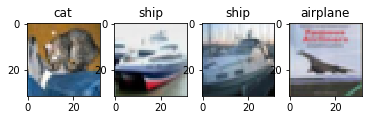

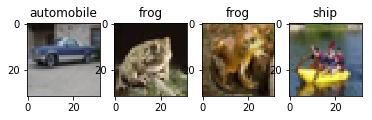

In [5]:
show(test_batch,0,4)
show(data_batch,10000,4)

In [6]:
for p in ['cifar10.py','cifar10_input.py','cifar10_train.py','cifar10_eval.py']:
    if(not os.path.exists(p)):
        RunSysCmd('wget https://raw.githubusercontent.com/tensorflow/models/master/'
                  'tutorials/image/cifar10/%s'%(p))

### Training
```sh
# chaneg IMAGE_SIZE to 32
sed -i "30c IMAGE_SIZE = 32" cifar10_input.py
# command to train the model
python cifar10_train.py --train_dir ./tmp --batch_size 128
# command to view the model
tensorboard --logdir="./tmp"
```
add below code to cifar10_eval.py API eval_once to export the model as frozen graph
```python
    if FLAGS.run_once:
      print('export frozen graph cifar10.pb')
      from tensorflow.python.framework import graph_util
      constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph_def, ['softmax_linear/softmax_linear/softmax_linear/sparsity'])
      with tf.gfile.FastGFile('./cifar10.pb', mode='wb') as f:
        f.write(constant_graph.SerializeToString())
```

eval the model and freeze the graph
```sh
python cifar10_eval.py --checkpoint_dir ./tmp --run_once --batch_size 128
```

In [16]:
RunSysCmd('python cifar10_eval.py --checkpoint_dir ./tmp --run_once --batch_size 128')

export frozen graph cifar10.pb
2019-02-10 12:41:40.350084: precision @ 1 = 0.809



### Tool to get Graph Inputs & Outputs

To find the inputs and outputs for the TensorFlow graph the model developer will know or you can consult TensorFlow's [summarize_graph](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/tools/graph_transforms) tool, for example:

```sh
summarize_graph --in_graph=cifar10.pb
```


In [8]:
sess = tf.InteractiveSession()
with tf.gfile.FastGFile('cifar10.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')

In [9]:
writer = tf.summary.FileWriter('./graphs', sess.graph)

view the frozen graph
```sh
tensorboard --logdir="./graphs"
```

In [10]:
x = sess.graph.get_tensor_by_name('batch:0')

In [11]:
y = sess.graph.get_tensor_by_name('softmax_linear/softmax_linear:0')

In [12]:
print(x,y)

Tensor("batch:0", dtype=float32) Tensor("softmax_linear/softmax_linear:0", shape=(128, 10), dtype=float32)


In [13]:
sess.run(tf.global_variables_initializer())

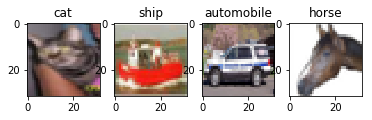

In [14]:
I = random.randint(0,10000-128)
show(test_batch,I,4)
im = test_batch[b'data'][I:I+128].reshape(128,3,32,32).transpose(0,2,3,1)
a = sess.run(y, feed_dict={x: im})

In [15]:
print(a.shape, a[0])

(128, 10) [-20.41772    -5.8387384  -4.4289827  27.073019   -5.6337996  21.879677
  22.99838   -27.457119   12.35456   -20.2583   ]


[freeze graph](https://github.com/onnx/tensorflow-onnx#freeze_graph) and [convert to onnx format](https://github.com/onnx/tensorflow-onnx#usage)
* not working maybe parameter wrong

```sh
python -m tensorflow.python.tools.freeze_graph --input_graph=./tmp/graph.pbtxt --input_binary=false --output_node_names=softmax_linear --input_checkpoint=./tmp --output_graph=cifar10-frozen.pb

python -m tf2onnx.convert --input cifar10-frozen.pb  --output cifar10-onnx.pb --inputs batch:0 --outputs softmax_linear/softmax_linear:0
```

In [ ]:
import tf2onnx
onnx_graph = tf2onnx.tfonnx.process_tf_graph(sess.graph, output_names=["softmax_linear/softmax_linear:0"])
model_proto = onnx_graph.make_model("cifar10")
with open("cifar.onnx", "wb") as f:
    f.write(model_proto.SerializeToString())